# Main Results

Contents
1.   [Libraries](#cell-1)
2.   [Auxiliary Functions](#cell-2)
3.   [Baseline CRPS Function](#cell-3)
4.   [Run Baselines](#cell-4)

<a href="https://colab.research.google.com/github/kdgutier/hint/blob/main/nbs/ablation_reconciliation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="cell-1"></a>
# 1. Libraries

In [1]:
# %%capture
!pip install datasetsforecast
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git
!git clone https://github.com/dluuo/HINT.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135

In [2]:
# %%capture
import os
import re
import pprint

import torch
import numpy as np
import pandas as pd

#import wrangled datasets
from HINT.src.data.data import HierarchicalDataset

from typing import Optional, Union, Tuple

from torch.distributions import NegativeBinomial


# Hierarchical Evaluation
from hierarchicalforecast.utils import CodeTimer
from hierarchicalforecast.evaluation import scaled_crps

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, HINT

from neuralforecast.losses.pytorch import PMM, GMM, DistributionLoss
from neuralforecast.losses.pytorch import MQLoss, sCRPS

In [3]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 22

In [4]:
import numpy as np
import pandas as pd

from neuralforecast.utils import augment_calendar_df

from hierarchicalforecast.evaluation import scaled_crps, msse
from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

In [5]:
#@title run_ablation
# def run_ablation(dataset, verbose=False):
#assert dataset=='TourismLarge', 'Check futr_exog_list induced leakage'
dataset = 'TourismLarge' # 'Labour'
verbose = False

with CodeTimer('Read and Parse data   ', verbose):
    hdataset = HierarchicalDataset()
    data = hdataset.load_process_data(dataset=dataset)
    
    # Experiment parameters
    horizon = data['horizon']
    freq = data['freq']
    Y_df = data['Y_df']
    S_df = data['S_df']
    level = np.arange(0, 100, 2)
    qs = [[50-lv/2, 50+lv/2] for lv in level]
    QUANTILES = np.sort(np.concatenate(qs)/100)
    HIER_IDXS = data['hier_idxs']

    n_series = len(S_df)
    n_quantiles = len(QUANTILES)

with CodeTimer('Fit/Predict Model	 ', verbose):
    nhits = NHITS(h=horizon,
                  input_size=24,
                  loss=GMM(n_components=10, level=list(level)),
                  hist_exog_list=['month'],
                  max_steps=1000,
                  early_stop_patience_steps=10,
                  val_check_steps=50,
                  scaler_type='robust',
                  learning_rate=1e-3,
                  valid_loss=sCRPS(level=list(level)),
                  batch_size=4,
                  valid_batch_size=n_series)
    bottomup = HINT(h=horizon, S=S_df.values, model=nhits,
                   reconciliation='BottomUp', alias='NHITS-bu')
    mintrols = HINT(h=horizon, S=S_df.values, model=nhits,
                   reconciliation='MinTraceOLS', alias='NHITS-mint-ols')
    
    nf = NeuralForecast(models=[nhits, bottomup, mintrols], freq=freq)
    Y_hat_df = nf.cross_validation(df=Y_df, val_size=12, n_windows=1)

    #sort raw predictions by uid to make sure they are hierarchically ordered
    #Y_hat_df = hdataset._sort_hier_df(Y_hat_df, S_df)

    # Group by cutoff date
    #Y_hat_group_df = Y_hat_df.groupby(['cutoff'])
    Y_hat_df = Y_hat_df.sort_values(by=['cutoff','unique_id'])
    Y_test_df = Y_hat_df['y']
    tags = data['tags']

# return S_df, Y_test_df, Y_hat_df, nf, data, quantiles, tags, Y_df

100%|██████████| 1.30M/1.30M [00:04<00:00, 270kiB/s]
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [6]:
Y_hat_df

,unique_id,ds,cutoff,NHITS,NHITS-median,NHITS-lo-98,NHITS-lo-96,NHITS-lo-94,NHITS-lo-92,NHITS-lo-90,...,NHITS-mint-ols-hi-84,NHITS-mint-ols-hi-86,NHITS-mint-ols-hi-88,NHITS-mint-ols-hi-90,NHITS-mint-ols-hi-92,NHITS-mint-ols-hi-94,NHITS-mint-ols-hi-96,NHITS-mint-ols-hi-98,y,month
0,TotalAll,2016-01-01,2015-12-01,41585.546875,42975.996094,19397.871094,21331.732422,22025.875000,23015.195312,24000.687500,...,49225.234375,49669.773438,49981.781250,50479.488281,51224.480469,52132.464844,53365.347656,56706.289062,45625.487797,-0.500000
1,TotalAll,2016-02-01,2015-12-01,21365.492188,21303.933594,14226.304688,15304.993164,16873.515625,17386.917969,18055.423828,...,22813.369141,22893.066406,22946.156250,23064.519531,23199.238281,23341.996094,23468.232422,23777.587891,23227.928309,-0.409091
2,TotalAll,2016-03-01,2015-12-01,23706.125000,23244.710938,8663.070312,15010.152344,17360.164062,18151.267578,18642.460938,...,26076.019531,26198.330078,26256.730469,26423.718750,26578.771484,26771.683594,27219.308594,27704.964844,25156.548833,-0.318182
3,TotalAll,2016-04-01,2015-12-01,29687.689453,28835.800781,18676.648438,22208.955078,22933.451172,23363.363281,23598.660156,...,32229.384766,32374.013672,32599.453125,33045.273438,33353.621094,33632.804688,34039.183594,34666.867188,27581.721323,-0.227273
4,TotalAll,2016-05-01,2015-12-01,22456.884766,22123.863281,17793.529297,18298.812500,18393.917969,18613.839844,18752.376953,...,24195.078125,24382.470703,24476.357422,24650.882812,24837.865234,25028.935547,25320.976562,25938.046875,24489.221902,-0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,GBDOth,2016-08-01,2015-12-01,3.784583,0.345471,-10.818702,-1.684282,-1.317910,-1.084348,-1.020419,...,35.561714,39.078156,41.609692,44.490433,46.781719,50.147396,60.656853,77.736610,0.000000,0.136364
6656,GBDOth,2016-09-01,2015-12-01,3.320618,0.479991,-8.114800,-1.396509,-1.118163,-1.034037,-0.924575,...,31.625799,33.301720,35.686451,39.430920,42.521175,45.927170,52.535416,69.113174,0.000000,0.227273
6657,GBDOth,2016-10-01,2015-12-01,3.673048,0.233729,-7.837299,-1.593730,-1.397514,-1.250493,-1.171771,...,38.925804,40.813663,42.853455,45.773319,49.991600,54.645344,66.417656,71.365211,0.000000,0.318182
6658,GBDOth,2016-11-01,2015-12-01,2.881370,0.131081,-14.802714,-2.924389,-1.343535,-1.160382,-1.037879,...,40.571117,43.809906,46.793190,51.165386,55.843189,61.266106,70.904678,88.601028,0.000000,0.409091


<a name="cell-4"></a>
# 4. Run Baselines

In [7]:
if 'Auto' in type(nf.models[0]).__name__:
    pprint.pprint(nf.models[0].results.get_best_result().config)
    print(nf.models[0].results.get_best_result().metrics['loss'])

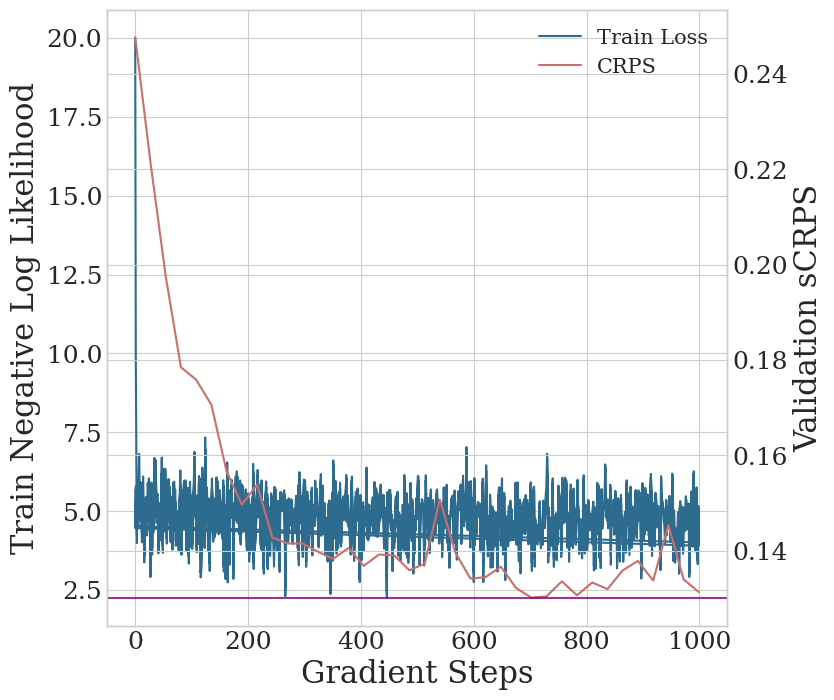

In [8]:
if 'Auto' in type(nf.models[0]).__name__:
    # Parse AutoModel trajectories
    train_loss = np.array(nf.models[0].model.train_trajectories)
    valid_loss = np.array(nf.models[0].model.valid_trajectories)
else:
    # Parse Model trajectories
    train_loss = np.array(nf.models[1].model.train_trajectories)
    valid_loss = np.array(nf.models[1].model.valid_trajectories)

valid_steps = np.linspace(0, max(train_loss[:,0]), len(valid_loss))

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

l1, = ax1.plot(train_loss[:,0], train_loss[:,1],
               label='Train', color='#2D6B8F')
l2, = ax2.plot(valid_steps, valid_loss[:,1],
              label='Validation', color='#CA6F6A')

plt.axhline(min(valid_loss[:,1]), color='purple', alpha=0.8)
ax1.set_ylabel('Train Negative Log Likelihood', fontsize=22)
ax2.set_ylabel('Validation sCRPS', fontsize=22)
ax1.set_xlabel('Gradient Steps', fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
plt.legend([l1, l2], ["Train Loss", "CRPS"], fontsize=15)
plt.show()
plt.close()

In [9]:
def parse_predictions(Y_hat_df, model_name):
    quantile_columns = [model_name + n for n in nhits.loss.output_names]
    quantile_columns.remove(model_name + '-median')
    y_rec  = Y_hat_df[quantile_columns].values 
    y_test = Y_hat_df['y'].values

    n_windows_cv = len(Y_hat_df.cutoff.unique())
    n_series = len(Y_hat_df.unique_id.unique())
    n_quantiles = len(quantile_columns)    

    y_rec  = y_rec.reshape(n_windows_cv, n_series, -1, n_quantiles)
    y_test = y_test.reshape(n_windows_cv, n_series, -1, 1)
    return y_rec, y_test

In [10]:
horizon = data['horizon']
test_size = horizon
val_size = horizon
n_windows_cv = len(Y_hat_df.cutoff.unique())

test_df  = Y_df.groupby('unique_id').tail(test_size)
Y_train_df = Y_df.drop(test_df.index)
Y_train = Y_train_df.y.values.reshape(n_series,-1)
Y_hier = Y_df.y.values.reshape(n_series,-1)

Y_hat, Y_test = parse_predictions(Y_hat_df, 'NHITS')
Y_tilde_bu, _ = parse_predictions(Y_hat_df, 'NHITS-bu')
Y_tilde_mint_ols, _ = parse_predictions(Y_hat_df, 'NHITS-mint-ols')

# Eliminate default mean entry [mean, quantiles], keep quantiles
Y_hat = Y_hat[:,:,:,1:]
Y_tilde_bu = Y_tilde_bu[:,:,:,1:]
Y_tilde_mint_ols = Y_tilde_mint_ols[:,:,:,1:]

print('Y_train.shape (n_series,n_time) \t\t\t\t', Y_train.shape)
print('Y_test.shape (n_windows,n_series,horizon,1) \t\t\t', Y_test.shape)
print('Y_test.shape (n_windows,n_series,horizon,1) \t\t\t', Y_test.shape)
print('Y_hat.shape  (n_windows,n_series,horizon,n_quant) \t\t', Y_hat.shape)
print('Y_tilde_bu.shape    (n_windows_cv, n_series, horizon, n_quant) \t', Y_tilde_bu.shape)
print('Y_tilde_ols.shape   (n_windows_cv, n_series, horizon, n_quant) \t', Y_tilde_mint_ols.shape)

Y_train.shape (n_series,n_time) 				 (555, 216)
Y_test.shape (n_windows,n_series,horizon,1) 			 (1, 555, 12, 1)
Y_test.shape (n_windows,n_series,horizon,1) 			 (1, 555, 12, 1)
Y_hat.shape  (n_windows,n_series,horizon,n_quant) 		 (1, 555, 12, 100)
Y_tilde_bu.shape    (n_windows_cv, n_series, horizon, n_quant) 	 (1, 555, 12, 100)
Y_tilde_ols.shape   (n_windows_cv, n_series, horizon, n_quant) 	 (1, 555, 12, 100)


In [11]:
def plot_single_prediction(ax, x_plot, y_plot_hat, color='blue'): 
    # print(quantiles.index(0.25))
    # print(quantiles.index(0.75))
    # print(quantiles.index(0.02))
    # print(quantiles.index(0.98))
    ax.plot(x_plot,y_plot_hat[:,49], 
            label='Forecast', color=color)
    ax.fill_between(x_plot,
                    y1=y_plot_hat[:,24], y2=y_plot_hat[:,73],
                    facecolor=color, alpha=0.4, label='[q25-q75]')
    ax.fill_between(x_plot,
                    y1=y_plot_hat[:,1], y2=y_plot_hat[:,96],
                    facecolor=color, alpha=0.2, label='[q1-q99]')

def plot_hierarchically_linked_predictions(data, b_idx, n_years=18,
                                           Y_hier=None,
                                           Y_hier_hat=None, plot_file=None):
    
    # This plots validate the S/X/Y_bottom
    # We check for the sinchronization of features with Y_bottom
    # We do the same for Y_agg, to check correct linkage
    assert b_idx < 304 and b_idx>=0
    fontsize = 30
    
    # Hierarchically linked target data and labels
    # [Total, State, Zone, Region, TotalP, StateP, ZoneP] [0, 1, 2, 3, 4, 5, 6]
    # [Total, State, Zone, Region] <--> [0, 1, 2, 3]
    linked_idxs = data['hier_linked_idxs'][b_idx][:4]
    print('linked_idxs', linked_idxs)
    hier_labels = data['S_df'].index
    hier_labels2 = {'AAAHol': 'AAAHol',
                    'AAAAll': 'AAA',
                    'AAAll': 'AA',
                    'AAll': 'A',
                    'TotalAll': 'Total'}

    n_hier, n_bottom = data['S_df'].values.shape
    n_agg = n_hier - n_bottom
    horizon = horizon = data['seasonality']
    
    # Base series and its label  n_agg=251 idx \in {0,...,304}
    #Y_hier = data['temporal']['y'].values.reshape(n_hier,-1)[:,:-12]
    Y_base  = Y_hier[b_idx + n_agg]
    label   = hier_labels[b_idx + n_agg]#.split('/')[-1]
    label = hier_labels2[label]
    
    x_plot = data['Y_df'].ds[:-horizon] # Skip future dates

    fig, axs = plt.subplots(len(linked_idxs)+1, 1, figsize=(12, 9))
    for idx, linked_idx in enumerate(linked_idxs):
        axs[idx].plot(x_plot[-horizon*n_years:], Y_hier[linked_idx,-horizon*n_years:]/1000,
                      color = '#2D6B8F', linewidth=1.5)
        
        if Y_hier_hat is not None:
            # Filter and plot predictions
            y_plot_hat = Y_hier_hat[linked_idx,:,:]/1000
            plot_single_prediction(ax=axs[idx],
                                   x_plot=x_plot[-horizon:], 
                                   y_plot_hat=y_plot_hat,
                                   color='blue')
        
        hier_label = hier_labels[linked_idx]#.split('/')[-1]
        hier_label = hier_labels2[hier_label]
        axs[idx].set_ylabel(f'{hier_label}', fontsize=fontsize, rotation=90)
        axs[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs[idx].set_xticks([])
        axs[idx].tick_params(labelsize=15)
    
    # Checking that Y_bottom and Y_hier match
    axs[4].plot(x_plot[-horizon*n_years:], Y_base[-horizon*n_years:]/1000,
                color = '#2D6B8F', linewidth=1.5, label='base')
    
    if Y_hier_hat is not None:
        y_plot_hat = Y_hier_hat[b_idx + n_agg,:,:]/1000
        plot_single_prediction(ax=axs[4],
                               x_plot=x_plot[-horizon:], 
                               y_plot_hat=y_plot_hat,
                               color='blue') #E3A39A, 7B3841
    
    axs[4].set_xlabel('Month', fontsize=fontsize-1)
    axs[4].set_ylabel(f'{label}', fontsize=fontsize, rotation=90)
    axs[4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[4].tick_params(labelsize=18)
    
    title = f'{label} Hierarchically Linked Series \n'
    title += 'Forecast Distribution [Millions of Tourist Visits]'
    #title += 'Forecast Distribution'
    plt.suptitle(title, y=1.05, fontsize=fontsize)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if plot_file is not None:
        plt.savefig(plot_file, bbox_inches='tight')
    plt.show()
    plt.close()

linked_idxs [ 0  1  8 35]


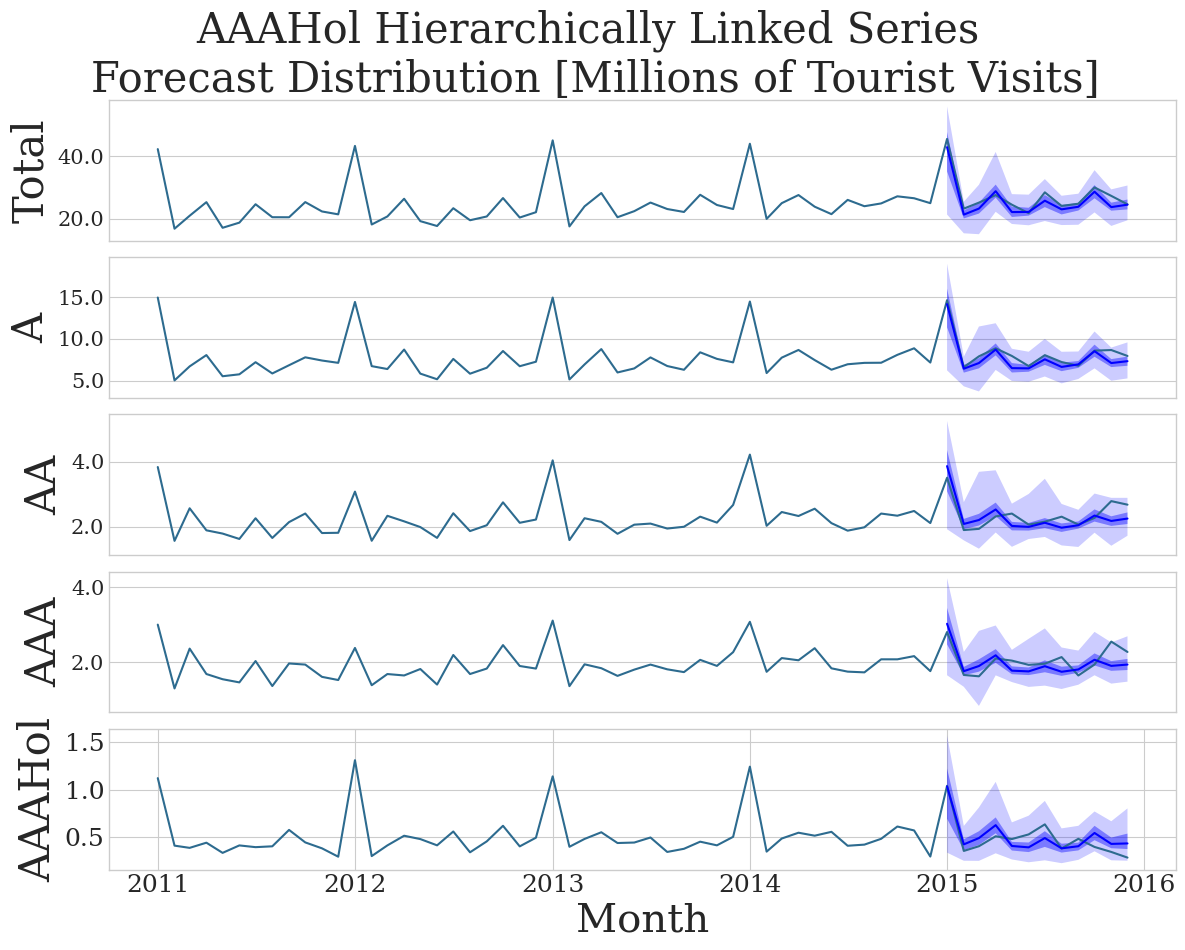

In [12]:
b_idx = 0
plot_hierarchically_linked_predictions(data=data, 
                                       Y_hier=Y_hier,
                                       Y_hier_hat=Y_hat[0,:,:,:], 
                                       b_idx=b_idx, n_years=5)

linked_idxs [ 0  1  8 35]


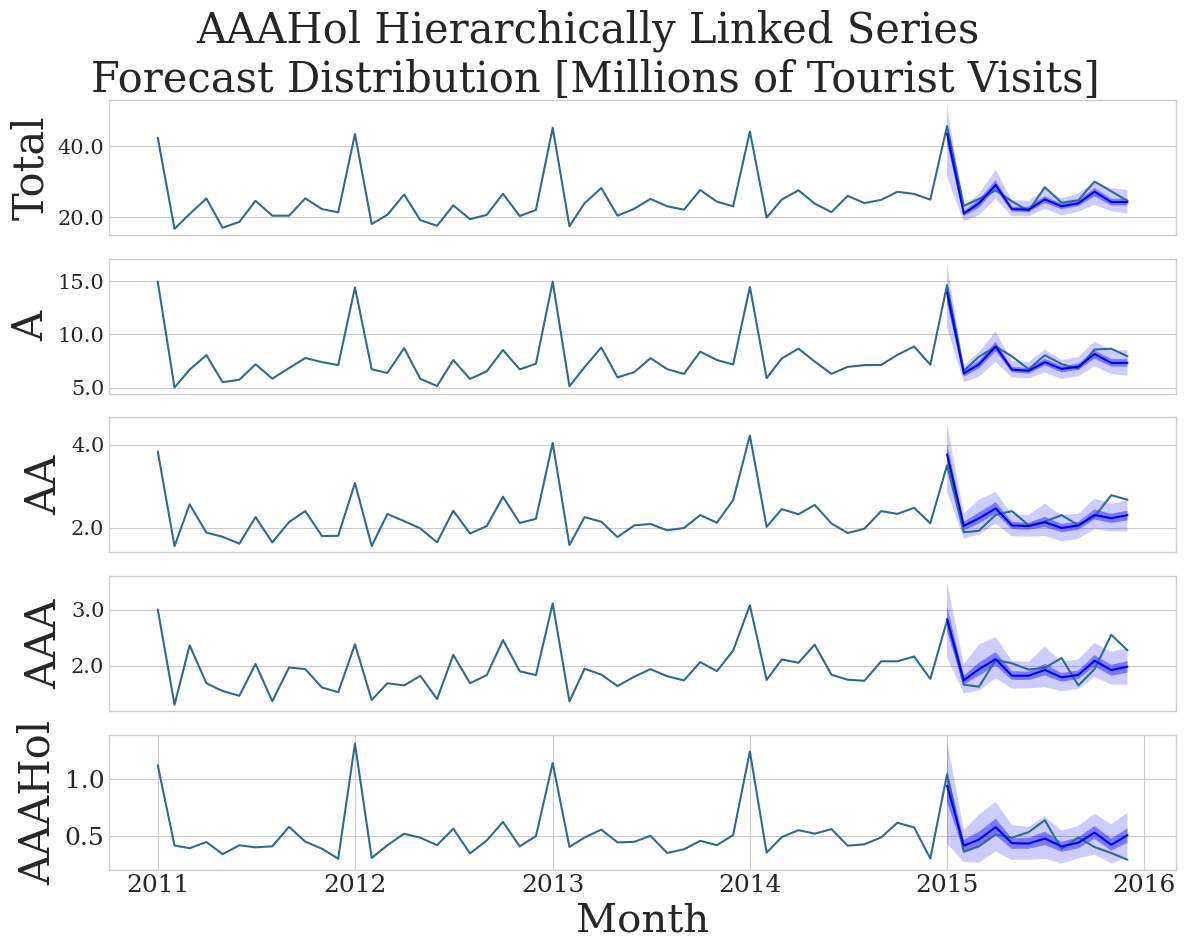

In [13]:
b_idx = 0
plot_hierarchically_linked_predictions(data=data,
                                       Y_hier=Y_hier, 
                                       Y_hier_hat=Y_tilde_mint_ols[0,:,:,:],
                                       b_idx=b_idx, n_years=5)

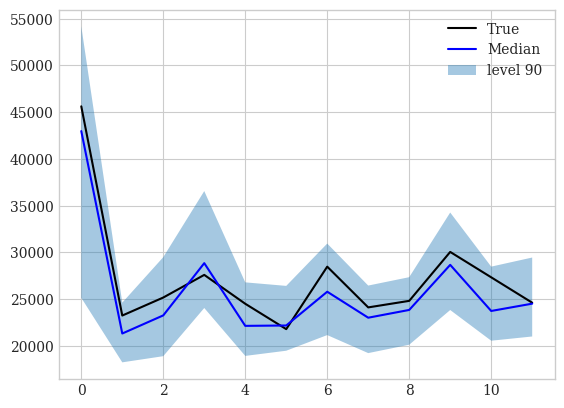

In [14]:
# Qualitative evaluation, of parsed quantiles
#Y_test.shape (n_windows,n_series,horizon,1) 			 (1, 57, 12, 1)
#Y_hat.shape  (n_windows,n_series,horizon,n_quant) 		 (1, 57, 12, 98)
u_idx = 0
plt.plot(Y_test[0, u_idx, :, 0], color='black', label='True')
plt.plot(Y_hat[0,u_idx,:,50], color='blue', label='Median')
plt.fill_between(x=np.arange(12),
                 y1=Y_hat[0,u_idx,:,5], 
                 y2=Y_hat[0,u_idx,:,93],
                 alpha=0.4, label='level 90')
plt.legend()
plt.show()
plt.close()

In [15]:
model_name = 'NHITS'

result = {'Dataset': [dataset] * len(['Overall'] + list(tags.keys())),
          'Level': ['Overall'] + list(tags.keys()),}

crps_list = [hdataset._get_hierarchical_scrps(Y=Y_test[window,:,:,0],
                                              Yq_hat=Y_hat[window,:,:,:],
                                              q_to_pred=QUANTILES, 
                                              hier_idxs=HIER_IDXS)
                                              for window in range(n_windows_cv)]
crps_hat = np.average(np.array(crps_list), axis=0)

crps_list = [hdataset._get_hierarchical_scrps(Y=Y_test[window,:,:,0],
                                              Yq_hat=Y_tilde_bu[window,:,:,:],
                                              q_to_pred=QUANTILES, 
                                              hier_idxs=HIER_IDXS)
                                              for window in range(n_windows_cv)]
crps_bu = np.average(np.array(crps_list), axis=0)

crps_list = [hdataset._get_hierarchical_scrps(Y=Y_test[window,:,:,0],
                                              Yq_hat=Y_tilde_mint_ols[window,:,:,:],
                                              q_to_pred=QUANTILES, 
                                              hier_idxs=HIER_IDXS)
                                              for window in range(n_windows_cv)]
crps_mint_ols = np.average(np.array(crps_list), axis=0)

result[model_name] = crps_hat
result[model_name+'-mint-ols'] = crps_mint_ols
result[model_name+'-bu'] = crps_bu

result_df = pd.DataFrame(result)
result_df

,Dataset,Level,NHITS,NHITS-mint-ols,NHITS-bu
0,TourismLarge,Overall,0.124530,0.130524,0.119184
1,TourismLarge,Country,0.045437,0.044937,0.030501
2,TourismLarge,Country/State,0.067912,0.065315,0.060694
3,TourismLarge,Country/State/Zone,0.107284,0.110054,0.104215
4,TourismLarge,Country/State/Zone/Region,0.151738,0.154296,0.148087
5,TourismLarge,Country/Purpose,0.076077,0.079196,0.073555
6,TourismLarge,Country/State/Purpose,0.117261,0.119692,0.111197
7,TourismLarge,Country/State/Zone/Purpose,0.182632,0.193905,0.178609
8,TourismLarge,Country/State/Zone/Region/Purpose,0.247899,0.276797,0.246612
